In [14]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import MinMaxScaler
import string
from nltk.corpus import stopwords
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import seaborn as sns

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define directories for each dataset
directories = {
    'agoda_hotel_reviews': (1, 10),  
    'tripadvisor_hotel_reviews': (1, 5),
    'klook_hotel_reviews': (1, 5),  
    'booking_hotel_reviews': (1, 10)
}

In [15]:
# Function to load and normalize data
def load_and_normalize_data():
    all_reviews = []
    for directory, (min_score, max_score) in directories.items():           
        path = os.path.join('raw data', directory)
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, filename))
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])
                all_reviews.append(df)
    return pd.concat(all_reviews, ignore_index=True)

# Load and normalize data
df = load_and_normalize_data()

In [16]:
# Function to lemmatize text
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()

    # Step 2: Remove punctuation
    # You can translate punctuation to None (removing it)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Tokenization
    tokens = nltk.word_tokenize(text)

    # Step 4: Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Step 5: Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return the processed text as a single string
    return ' '.join(lemmatized_tokens)

# Lemmatize the review content
df['cleaned_content'] = df['Review Content'].apply(preprocess_text)

In [17]:
# Convert normalized scores to binary labels (1 for positive, 0 for negative)
df['label'] = df['normalized_score'].apply(lambda x: 0 if x <= 0.25 else (2 if x >= 0.75 else 1))
print(df['label'].unique())
# print(df.head())

# print(df[['normalized_score', 'label']].describe())


[2 1 0]


In [18]:
# Split the data while maintaining class distribution
X = df['cleaned_content']
y = df['label'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# print("Class weights for training:", class_weight_dict)
# print(y_train)

# print("Unique labels in y_train:", np.unique(y_train))
# print("Label types in y_train:", y_train.dtype)
# print(f"Type of class_weight_dict: {type(class_weight_dict[y_train[0]])}")
# print(type(y_train.index))
# print(y_train.index)
# print(y_train.index.dtype)  # Check the data type of the index
# print("Class weights dictionary:", class_weight_dict)
# print("Unique classes in y_train:", y_train.unique())

Epoch 1/10


c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.6575 - loss: 1.1135 - val_accuracy: 0.7364 - val_loss: 1.0253
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.6065 - loss: 1.0938 - val_accuracy: 0.8082 - val_loss: 0.7958
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7657 - loss: 0.8628 - val_accuracy: 0.7552 - val_loss: 0.5960
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7354 - loss: 0.6711 - val_accuracy: 0.7922 - val_loss: 0.5335
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.7699 - loss: 0.5086 - val_accuracy: 0.7169 - val_loss: 0.5789
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.7902 - loss: 0.3810 - val_accuracy: 0.6904 - val_loss: 0.6428
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8108 - loss: 0.3752 - val_accuracy: 0.6994 - val_loss: 0.6389
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7787 - loss: 0.5653
Test Accuracy: 0.7771


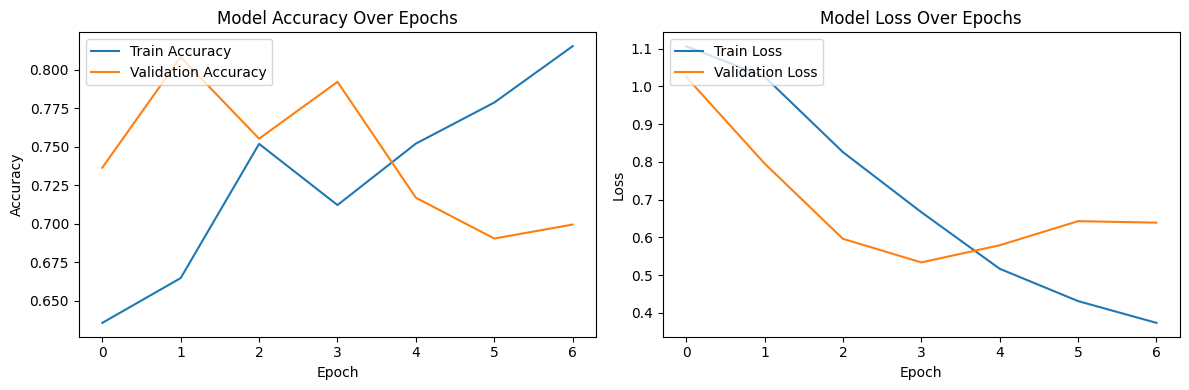

In [19]:


# Tokenizing the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to the same length
X_train_padded = pad_sequences(sequences_train, maxlen=100)
X_test_padded = pad_sequences(sequences_test, maxlen=100)

# Model Creation
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer for 3 classes: Negative, Neutral, Positive
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with class weights
# Attempt to fit the model

history = model.fit(
    X_train_padded, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2,   
    callbacks=[early_stopping],
    class_weight= class_weight_dict)

# Model Evaluation
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example input reviews
new_reviews = [
    {"review": "The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!", "score": 1.0},
    {"review": "The location was good, but the room had a strange smell and the service was just okay.", "score": 0.6},
    {"review": "I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.", "score": 0.2},
    {"review": "Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.", "score": 1.0},
    {"review": "The room was decent, but the Wi-Fi was slow and unreliable. It was an average stay overall.", "score": 0.5},
    {"review": "Terrible service! We waited over an hour for our room to be ready and the staff was not apologetic.", "score": 0.3},
    {"review": "The hotel was in a perfect location, close to all the major attractions. The room was comfortable and well-maintained.", "score": 0.9},
    {"review": "The facilities were outdated, and the air conditioning barely worked. I was disappointed with my stay.", "score": 0.4},
    {"review": "Great value for money! The hotel offered a lot of amenities and the staff was very friendly.", "score": 0.8},
    {"review": "The breakfast was good, but the room was small and the bed was uncomfortable. It was an okay stay.", "score": 0.6}
]

# Define a function to preprocess new input data
def preprocess_new_data(new_data):
    # Apply the same preprocessing function
    cleaned_data = [preprocess_text(entry["review"]) for entry in new_data]
    
    # Convert to sequences using the trained tokenizer
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as your training data

    return padded_sequences

# Prepare reviews for prediction
padded_sequences = preprocess_new_data(new_reviews)

# Make predictions
predictions = model.predict(padded_sequences)

# Interpreting the predictions
for i, prediction in enumerate(predictions):
    predicted_label = np.argmax(prediction)  # Get the index of the highest probability
    predicted_score = prediction[predicted_label]  # The probability of the predicted class
    actual_score = new_reviews[i]["score"]

    # Assign sentiment based on the predicted label
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    sentiment = sentiment_labels[predicted_label]

    # Print the results
    print(f"Review: {new_reviews[i]['review']}")
    print(f"Actual Score: {actual_score:.2f}")
    print(f"Predicted Label: {sentiment}")
    print(f"Negative Probability: {prediction[0]:.2f}")
    print(f"Neutral Probability: {prediction[1]:.2f}")
    print(f"Positive Probability: {prediction[2]:.2f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
Review: The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!
Actual Score: 1.00
Predicted Label: Positive
Negative Probability: 0.04
Neutral Probability: 0.25
Positive Probability: 0.71
--------------------------------------------------
Review: The location was good, but the room had a strange smell and the service was just okay.
Actual Score: 0.60
Predicted Label: Neutral
Negative Probability: 0.13
Neutral Probability: 0.46
Positive Probability: 0.41
--------------------------------------------------
Review: I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.
Actual Score: 0.20
Predicted Label: Negative
Negative Probability: 0.74
Neutral Probability: 0.23
Positive Probability: 0.04
--------------------------------------------------
Review: Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.
Actual Score